In [1]:
%pip install torchmetrics --quiet
%pip install --upgrade matplotlib --quiet

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import torchmetrics
from torchvision import transforms as T
import tqdm
from datetime import datetime
import matplotlib
matplotlib.__version__

'3.6.3'

# Adversarial Training for Free

In this notebook we reproduce some of the results of the ["Adversarial Training for Free!"](https://arxiv.org/pdf/1904.12843.pdf) paper, which provides a fast method for _adversarial training_ of neural networks.

## Adversarial attacks

Ad adversarial attack tries to perturbate some input samples so that the networks misclassifies them. The are two types of attacks to consider:

*   *non-targeted*
*   *targeted* 

The first ones, given a starting input x, its true label y, the loss function *l* and perturbation budget δ, generate new inputs that differ from the original input by at most δ but are classified with a different label, with no specific label as a target.
This is achieved by solving: 

$$\underset{δ}{max} \; l(x+δ,y,ϴ) \;\; \text{subject to} \;\; \lVert δ \rVert_{p} \leq ϵ.$$

On the other hand, *targeted attacks* additionally require the resulting input to be classified with a specific label. 

We will focus on _non-targeted_ attacks. One of the most used methods is the [FGSM method](https://pyimagesearch.com/2021/03/01/adversarial-attacks-with-fgsm-fast-gradient-sign-method/) that, given a sample x, generates an adversarial sample $x_{adv}$ as:

$$x_{adv}=x+ϵ∗sign(∇_xl(x,y,ϴ))$$

A more advanced technique to generate adversarial examples is the PGD-K attack, which iteratively builds a perturbation over k iterations of FGSM, with uniform random noise as initialization. This attacks is quite slow, since it needs to perform k gradient computations for each sample, but generates strong adversarial samples.

## Adversarial training

To defend against PGD-K and other strong attacks we can use _adversarial training_, which includes adversarial samples in the training set. Generating these examples is, however, a difficult task, since it involves running PGD-K or similar attacks to obtain strong samples. For a given $k$, training a minibatch requires $k+1$ forward/backward iterations in the K-PGD adversarial training algorithm.

The goal of this paper is to generate adversarial samples "for free", by recycling the gradient information computed when updating model parameters and generating adversarial examples with this information. Our results show that the training time of the model with the "adversarial free training" technique is never greater then classical training. To test the *free-training algorithm* we have used PGD-K, in particular PGD-20 and PGD-100.

In order to make our experiments consistent we have always worked on the same gpu to train the model, a **Tesla T4**

In [3]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-3f240056-3183-2af4-3777-3b138e7fdfcd)


For training and testing we have used the CIFAR-10 dataset, a collection of 60.000 32x32x3 images with 10 classes. We have also applied some transformations on it in order to do data augmentation.

In [4]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

transform = T.Compose([
        T.RandomRotation(15),
        T.RandomHorizontalFlip(),
        T.ToTensor()
])

batch_size = 64

train_data = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

test_data = CIFAR10(root='./data', train=False, download=True, transform=T.ToTensor())
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Since the paper focuses on the training algorithm and not the specifcs of the model, we have chosen to use the same architecture, ResNet, in its smallest configuration to keep the training time reasonable on colab.

The ResNet model features multiple blocks with residual connections, which allow for training a deeper model. Indeed, without the use of residual connections, the performance of deep models tends to decrease as the number of layers increases over some limit, limiting their generalization ability. Residual connections provide alternative paths for the data to flow unmodified inside the model and to skip given blocks. This makes deeper networks feasible to train

In [5]:
# From https://github.com/meliketoy/wide-resnet.pytorch/blob/master/networks/resnet.py

import torch.nn.init as init
from torch.autograd import Variable

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)

def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform(m.weight, gain=np.sqrt(2))
        init.constant(m.bias, 0)

def cfg(depth):
    depth_lst = [18, 34, 50, 101, 152]
    assert (depth in depth_lst), "Error : Resnet depth should be either 18, 34, 50, 101, 152"
    cf_dict = {
        '18': (BasicBlock, [2,2,2,2]),
        '34': (BasicBlock, [3,4,6,3]),
        '50': (Bottleneck, [3,4,6,3]),
        '101':(Bottleneck, [3,4,23,3]),
        '152':(Bottleneck, [3,8,36,3]),
    }

    return cf_dict[str(depth)]

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=True),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=True)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=True)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=True),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, depth, num_classes):
        super(ResNet, self).__init__()
        self.in_planes = 16

        block, num_blocks = cfg(depth)

        self.conv1 = conv3x3(3,16)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
def create_model():
  return ResNet(18, 10).to(device)

Training each version of the model takes some time, so we store trained models on github. The following code blocks define functions for loading and saving models.

In [8]:
! rm -rf repo && git clone https://github.com/dp1/adversarial-training-for-free repo

Cloning into 'repo'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 63 (delta 10), reused 25 (delta 4), pack-reused 0
Unpacking objects: 100% (63/63), 7.01 MiB | 7.75 MiB/s, done.


In [9]:
def save_model(name, model, training_metadata):
  torch.save({
      'metadata': training_metadata,
      'weights': model.state_dict()
  }, f'{name}.pth')

def load_model(name):
  data = torch.load(f'repo/models/{name}.pth')
  model = create_model()
  model.load_state_dict(data['weights'])
  return (model, data['metadata'])

In [10]:
import json
def save_data(name, metadata):
  with open(f'{name}.json', "w") as fout:
    json.dump(metadata, fout)

def load_data(name):
  with open(f'repo/models/{name}.json') as fin:
    data = json.load(fin)
    return data

## Classical training algorithm

In [11]:
def accuracy(net, loader, device):
  acc = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)
  for xb, yb in loader:
      xb, yb = xb.to(device), yb.to(device)
      ypred = net(xb)
      _ = acc(ypred, yb)
  return acc.compute()

In [12]:
def train_model(model, epochs=60):
  start_time = datetime.now()
  epoch_accuracies = []

  loss = nn.CrossEntropyLoss()
  opt = torch.optim.Adam(model.parameters())

  for epoch in range(epochs):
    model.train()
    for xb, yb in tqdm.tqdm(train_loader):
      
      xb, yb = xb.to(device), yb.to(device)

      opt.zero_grad()
      ypred = model(xb)
      l = loss(ypred, yb)
      l.backward()
      opt.step()

    model.eval()
    epoch_accuracies.append(float(accuracy(model, test_loader, device)))
    print(f'Accuracy at epoch {epoch}: {epoch_accuracies[-1]}')
  
  training_time = datetime.now() - start_time
  print(f'Training took {training_time}')

  return {
      'training_seconds': round(training_time.total_seconds()),
      'epoch_accuracies': epoch_accuracies
  }

In [13]:
#model = create_model()
#accuracy(model, test_loader, device)
#training_metadata = train_model(model, epochs=60)
#save_model('resnet-natural', model, training_metadata)

## PGD-k attack implementation

In [14]:
%pip install torchattacks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import torchattacks

In [16]:
def test_pgd_attack(model, k=20):
  atk = torchattacks.PGD(model, steps=k)
  adversarial = [[atk(test_x, test_y), test_y] for test_x, test_y in test_loader]
  
  acc_normal = float(accuracy(model, test_loader, device))
  acc_adversarial = float(accuracy(model, adversarial, device))
  
  print(f'Accuracy on normal dataset: {acc_normal}')
  print(f'Accuracy on adversarial samples: {acc_adversarial}')
  return acc_normal, acc_adversarial

In [17]:
#test_pgd_attack(model, k=5)

## Free Training Algorithm

The key idea of the algorithm is to build a perturbation for the given training samples in multiple iterations, thus allowing for generating complex perturbations that should be resistent to PGD-K attacks. This is achieved by training on each minibatch $m$ times, and dividing the number of epochs by $m$ to keep the training time roughly constant.

Each iteration performs an FGSM step and constrains the perturbation to be within the limit $\epsilon$. The perturbation for each minibatch is initialized from the previous one (if any) to warm start the algorithm

In [18]:
from torch.autograd import Variable

def free_training(model, epochs=60, m=1, eps=8/255):
  start_time = datetime.now()
  epoch_accuracies = []

  loss = nn.CrossEntropyLoss()
  opt = torch.optim.Adam(model.parameters())

  d = torch.zeros([batch_size, 3, 32, 32]).to(device)

  for epoch in range(epochs // m):

    model.train()
    for xb, yb in tqdm.tqdm(train_loader):
      xb, yb = xb.to(device), yb.to(device)
      
      for _ in range(m):

        cur_batch_size = xb.shape[0]
        delta = Variable(d[:cur_batch_size], requires_grad=True)
        x_adv = xb + delta

        opt.zero_grad()
        ypred = model(x_adv)
        l = loss(ypred, yb)
        l.backward()

        pert = torch.sign(delta.grad) * eps
        d[:cur_batch_size] += pert.data
        d.clamp_(-eps, eps)
        
        opt.step()

    model.eval()
    epoch_accuracies.append(float(accuracy(model, test_loader, device)))
    print(f'Accuracy at epoch {epoch}: {epoch_accuracies[-1]}')
    
  training_time = datetime.now() - start_time
  print(f'Training took {training_time}')

  return {
      'training_seconds': round(training_time.total_seconds()),
      'epoch_accuracies': epoch_accuracies
  }

Free training was done as follows, with the models being saved on github.

In [ ]:
#for m in [1,2,4,6,10,15,30,60]:
  #model_adv = create_model()
  #training_metadata = free_training(model_adv, epochs=60, m=m, eps=8/255)
  #print(training_metadata)
  #save_model(f'resnet-m={m}', model_adv, training_metadata)

## Evaluation for different values of m

In [17]:
model, meta = load_model("resnet-natural")
acc_normal, acc_adv20 = test_pgd_attack(model, k=20)
_, acc_adv100 = test_pgd_attack(model, k=100)
time = meta["training_seconds"]

meta = {"natural": acc_normal,
          "pgd20_acc": acc_adv20,
          "pgd100_acc": acc_adv100,
          "train_time": time }
save_data("data-natural", meta)


for m in [1,2,4,6,10,15,30,60]:
  model, meta = load_model("resnet-m="+str(m))
  acc_normal, acc_adv20 = test_pgd_attack(model, k=20)
  _, acc_adv100 = test_pgd_attack(model, k=100)
  time = meta["training_seconds"]
  meta = {"natural": acc_normal,
          "pgd20_acc": acc_adv20,
          "pgd100_acc": acc_adv100,
          "train_time": time }
  save_data("data-m="+str(m), meta)

Accuracy on normal dataset: 0.8676999807357788
Accuracy on adversarial samples: 0.0
Accuracy on normal dataset: 0.8676999807357788
Accuracy on adversarial samples: 0.0
Accuracy on normal dataset: 0.8618000149726868
Accuracy on adversarial samples: 0.00039999998989515007
Accuracy on normal dataset: 0.8618000149726868
Accuracy on adversarial samples: 0.0
Accuracy on normal dataset: 0.791100025177002
Accuracy on adversarial samples: 0.2689000070095062
Accuracy on normal dataset: 0.791100025177002
Accuracy on adversarial samples: 0.24660000205039978
Accuracy on normal dataset: 0.6782000064849854
Accuracy on adversarial samples: 0.37599998712539673
Accuracy on normal dataset: 0.6782000064849854
Accuracy on adversarial samples: 0.3626999855041504
Accuracy on normal dataset: 0.6470999717712402
Accuracy on adversarial samples: 0.37459999322891235
Accuracy on normal dataset: 0.6470999717712402
Accuracy on adversarial samples: 0.3684999942779541
Accuracy on normal dataset: 0.5730999708175659
Acc

## Testing instructions

To test the complete algorithm for a given $m$ and $k$, the following code can be used.

In [47]:
m = 4
k = 20
model_adv = create_model()
training_metadata = free_training(model_adv, epochs=60, m=m, eps=8/255)
acc_natural, acc_adv = test_pgd_attack(model_adv, k=k)

100%|██████████| 782/782 [01:02<00:00, 12.47it/s]


Accuracy at epoch 0: 0.4551999866962433


100%|██████████| 782/782 [01:02<00:00, 12.52it/s]


Accuracy at epoch 1: 0.5267000198364258


100%|██████████| 782/782 [01:01<00:00, 12.66it/s]


Accuracy at epoch 2: 0.5633999705314636


100%|██████████| 782/782 [01:00<00:00, 12.88it/s]


Accuracy at epoch 3: 0.5855000019073486


100%|██████████| 782/782 [01:01<00:00, 12.75it/s]


Accuracy at epoch 4: 0.6173999905586243


100%|██████████| 782/782 [01:01<00:00, 12.71it/s]


Accuracy at epoch 5: 0.632099986076355


100%|██████████| 782/782 [01:01<00:00, 12.65it/s]


Accuracy at epoch 6: 0.6399000287055969


100%|██████████| 782/782 [01:03<00:00, 12.38it/s]


Accuracy at epoch 7: 0.6395999789237976


100%|██████████| 782/782 [01:02<00:00, 12.49it/s]


Accuracy at epoch 8: 0.6610000133514404


100%|██████████| 782/782 [01:01<00:00, 12.68it/s]


Accuracy at epoch 9: 0.6593000292778015


100%|██████████| 782/782 [01:01<00:00, 12.79it/s]


Accuracy at epoch 10: 0.656499981880188


100%|██████████| 782/782 [01:02<00:00, 12.52it/s]


Accuracy at epoch 11: 0.6769000291824341


100%|██████████| 782/782 [01:02<00:00, 12.42it/s]


Accuracy at epoch 12: 0.6938999891281128


100%|██████████| 782/782 [01:02<00:00, 12.48it/s]


Accuracy at epoch 13: 0.6876999735832214


100%|██████████| 782/782 [01:02<00:00, 12.56it/s]


Accuracy at epoch 14: 0.691100001335144
Training took 0:16:06.648421
Accuracy on normal dataset: 0.691100001335144
Accuracy on adversarial samples: 0.3614000082015991


# Results

In [19]:
for m in [1,2,4,6,10,15,30,60]:
  #model, meta = load_model("resnet-m="+str(m))
  meta_data = load_data("data-m="+str(m))
  #acc_normal, acc_adv = test_pgd_attack(model, k=20)
  train_time = meta_data["train_time"]
  acc_normal = meta_data["natural"]
  acc_adv20 = meta_data["pgd20_acc"]
  acc_adv100 = meta_data["pgd100_acc"]
  print(f"...........................m={m}.........................................")
  print(f"Model: Resnet-m={m}, training time: {train_time}s")
  print(f"Accuracy on NATURAL dataset: {acc_normal}")
  print(f"Accuracy on ADVERSARIAL dataset (PGD-20): {acc_adv20}")
  print(f"Accuracy on ADVERSARIAL dataset (PGD-100): {acc_adv100}")
  print()

...........................m=1.........................................
Model: Resnet-m=1, training time: 1644s
Accuracy on NATURAL dataset: 0.8618000149726868
Accuracy on ADVERSARIAL dataset (PGD-20): 0.00039999998989515007
Accuracy on ADVERSARIAL dataset (PGD-100): 0.0

...........................m=2.........................................
Model: Resnet-m=2, training time: 1187s
Accuracy on NATURAL dataset: 0.791100025177002
Accuracy on ADVERSARIAL dataset (PGD-20): 0.2689000070095062
Accuracy on ADVERSARIAL dataset (PGD-100): 0.24660000205039978

...........................m=4.........................................
Model: Resnet-m=4, training time: 938s
Accuracy on NATURAL dataset: 0.6782000064849854
Accuracy on ADVERSARIAL dataset (PGD-20): 0.37599998712539673
Accuracy on ADVERSARIAL dataset (PGD-100): 0.3626999855041504

...........................m=6.........................................
Model: Resnet-m=6, training time: 863s
Accuracy on NATURAL dataset: 0.6470999717712402


## Accuracy on natural data

Just like in the paper, we see a decrease in accuracy for the natural dataset as $m$ increases. This is due to increased generalization error when repeating epochs multiple times. Informally, the networks tends to forget about earlier minibatches more as the replay count increases. In the worst case where most of the information is in the first minibatch, the model would tend to ignore most of it for a sufficiently high $m$.

Conversely increasing $m$ leads to an increase in robustness, which we will explore in the next section.

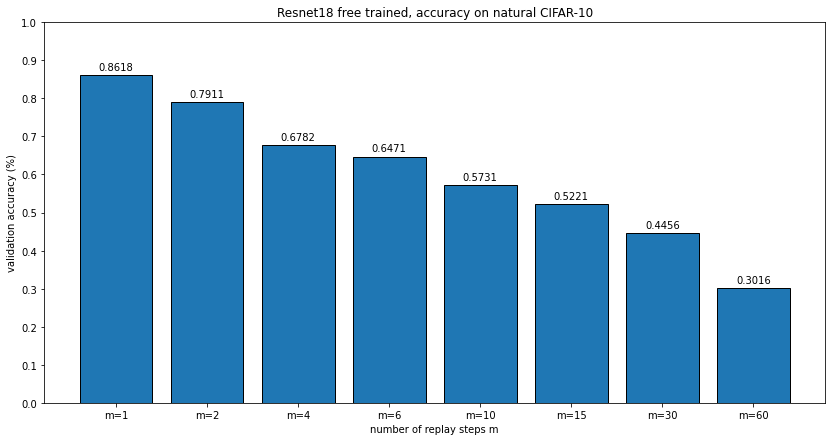

In [24]:
fig,axes=plt.subplots(figsize=(14, 7))
axes.set_title("Resnet18 free trained, accuracy on natural CIFAR-10")
axes.set_xlabel("number of replay steps m")
axes.set_ylabel("validation accuracy (%)")
categories = ["m=1", "m=2", "m=4", "m=6", "m=10", "m=15", "m=30", "m=60"] 
output = []

for m in [1,2,4,6,10,15,30,60]:
  data = load_data("data-m="+str(m))
  accuracy_m = data["natural"]
  output.append(accuracy_m)
  
axes.set_yticks(np.linspace(0,1,11))
axes.set_ylim(0,1)
b=axes.bar(categories, output, edgecolor="black")
axes.bar_label(b, padding=3)
plt.show()

## Accuracy over adversarial samples

In this plot we can see the positive effect of a higher $m$ value on robustness against adversarial attacks. This is true up to a point, which in our case is reached at $m=4$.

For this value, we have the highest accuracy on adversarial samples, while maintaning an acceptable accuracy on the natural data, considering the limited size of our model and training time.

In [25]:
import pandas as pd
train_algs = ['Natural', 'Free m=2', 'Free m=4', 'Free m=6', 'Free m=10', 'Free m=15', 'Free m=30']
natural_data = []
pgd_20 = []
pgd_100 = []
time = []

# NATURAL TRAINING
data = load_data("data-natural")
time.append(data["train_time"] / 60)
pgd_20.append(data["pgd20_acc"])
pgd_100.append(data["pgd100_acc"])
natural_data.append(data["natural"])

# FREE TRAINING
for m in [2,4,6,10,15,30]:
  meta = load_data("data-m="+str(m))
  time.append(meta["train_time"] / 60)
  pgd_20.append(meta["pgd20_acc"])
  pgd_100.append(meta["pgd100_acc"])
  natural_data.append(meta["natural"])

data = {'Natural-Dataset': natural_data,
        'PGD-20':pgd_20,
        'PGD-100':pgd_100,
        'Training-Time (min)':time}
table=pd.DataFrame(data, dtype=float, index= train_algs)
print(table)

           Natural-Dataset  PGD-20  PGD-100  Training-Time (min)
Natural             0.8677  0.0000   0.0000            27.166667
Free m=2            0.7911  0.2689   0.2466            19.783333
Free m=4            0.6782  0.3760   0.3627            15.633333
Free m=6            0.6471  0.3746   0.3685            14.383333
Free m=10           0.5731  0.3560   0.3402            13.300000
Free m=15           0.5221  0.3471   0.3391            12.666667
Free m=30           0.4456  0.2788   0.2725            11.933333


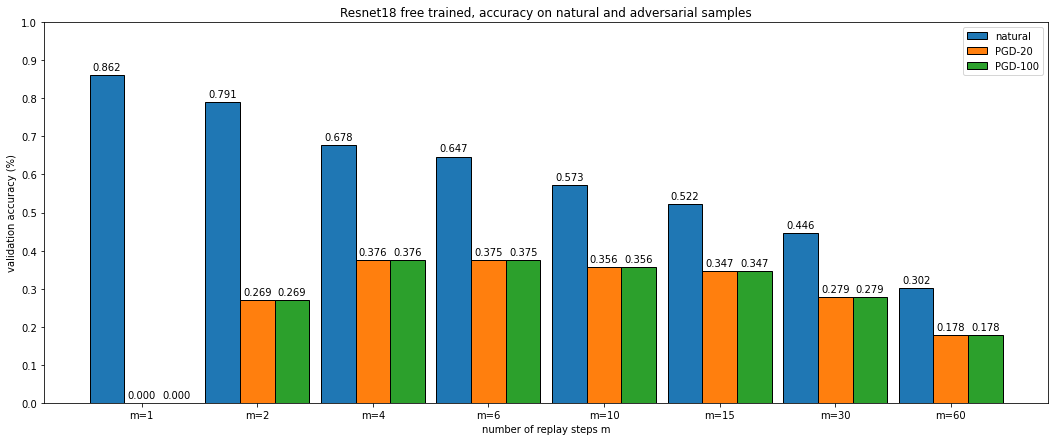

In [46]:
fig,axes=plt.subplots(figsize=(18, 7))
axes.set_xlabel("number of replay steps m")
axes.set_ylabel("validation accuracy (%)")
categories = ["m=1", "m=2", "m=4", "m=6", "m=10", "m=15", "m=30", "m=60"] 

output = []
output_20 = []
output_100 = []

for m in [1,2,4,6,10,15,30,60]:
  data = load_data("data-m="+str(m))
  output.append(data["natural"])
  output_20.append(data["pgd20_acc"])
  output_100.append(data["pgd100_acc"])

width=0.3
x = np.arange(len(categories))
axes.set_title("Resnet18 free trained, accuracy on natural and adversarial samples")
axes.set_yticks(np.linspace(0,1,11))
axes.set_ylim(0,1)
b0=axes.bar(x-width, output, width, edgecolor="black", label="natural")
b1=axes.bar(x, output_20, width, edgecolor="black", label="PGD-20")
b2=axes.bar(x+width, output_20, width, edgecolor="black", label="PGD-100")
axes.bar_label(b0, fmt="%.3f", padding=3)
axes.bar_label(b1, fmt="%.3f", padding=3)
axes.bar_label(b2, fmt="%.3f", padding=3)
axes.set_xticks(x, categories)
axes.legend()
plt.show()